In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib widget
plt.close('all')


def create_input_PSD(freq_range):
    psd = np.zeros_like(freq_range)
    bump_location = np.where(np.abs(freq_range-injectFreq)<injectWidth)
    psd[bump_location] = injectPow  # Add signal
    return psd

def create_LO_bleed_PSD(freq_range):
    psd = np.full(len(freq_range), 0)
    bump_location = np.where(np.abs(freq_range-LO)<injectWidth)
    psd[bump_location] = LO_bleed  # Add signal
    return psd

def RF_filter(freq_range, fromDataFlag = 0, path = None):
    if fromDataFlag == 0:
        filter_response = -100 * np.ones_like(freq_range)  # Initialize with high attenuation
        within_band = (freq_range >= rfStart) & (freq_range <= rfStop)
        filter_response[within_band] = 0  # 0 dB loss within the band
    else:
        data_path = path
        filter_response = get_filter_response_from_data(data_path, freq_range)

    return filter_response

def mixer(freq_range, LO):
    difference = LO - freq_range  # Difference frequencies
    low_side = np.where(difference >= 0, difference, np.nan)  # Take only the positive values, make others NaN
    high_side = np.where(difference < 0, -difference, np.nan)  # Take negative values, make them positive, make others NaN
    return low_side, high_side

def get_filter_response_from_data(data_path, freq_range_in_ghz):
    # Load the data
    data = np.loadtxt(data_path)
    
    # Convert from Hz to GHz
    frequencies_in_ghz = data[:, 0] * 1e-3
    insertion_losses = data[:, 1]
    
    # Interpolate
    interpolation_function = interp1d(frequencies_in_ghz, insertion_losses, bounds_error=False, fill_value=100)
    return interpolation_function(freq_range_in_ghz)

def IF_filter(freq_range, fromDataFlag = 0, path=None ):
    if fromDataFlag == 0:
        filter_response = -100 * np.ones_like(freq_range)  # Initialize with high attenuation
        within_band = (freq_range >= ifStart) & (freq_range <= ifStop)  # Filtering the IF within 0 to 2 GHz range
        filter_response[within_band] = 0  # 0 dB loss within the band
    else:     
        data_path = path
        filter_response = get_filter_response_from_data(data_path, freq_range)
    return filter_response

def combined_IF_power(freq_range, rf_filtered, LO):
    half_point = np.searchsorted(freq_range, LO)
    combined_if = np.zeros(half_point)  # IF will be half the size of the original signal
    for i, freq in enumerate(freq_range[:half_point]):
        low_power = 10 ** (rf_filtered[np.argmin(np.abs(freq_range - (LO - freq)))] / 10)
        high_power = 10 ** (rf_filtered[np.argmin(np.abs(freq_range - (LO + freq)))] / 10)
        combined_if[i] = 10 * np.log10(low_power + high_power)
    return freq_range[:half_point], combined_if


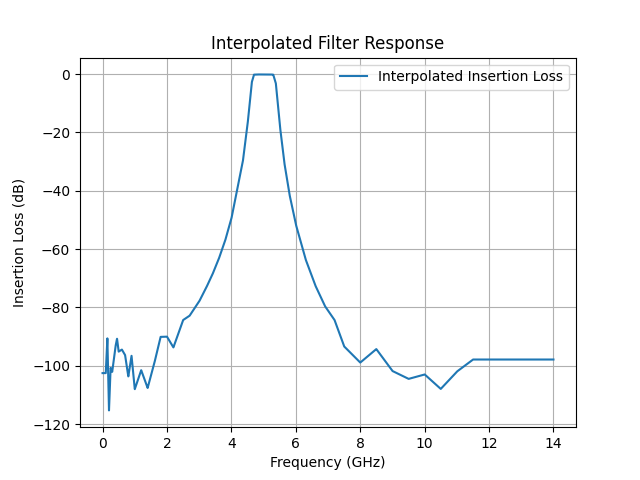

In [2]:
import numpy as np
from scipy.interpolate import interp1d

freq_range = np.linspace(1, 14, 10000)

def read_and_interpolate_filter_data(file_path, freq_range):
    # Read data from the file
    with open(file_path, 'r') as file:
        data = np.array([list(map(float, line.split())) for line in file])
    
    # Extract frequency and insertion loss data
    #assumes freqs are in MHz (like minicircuits does)
    freqs = data[:, 0]/1e3
    insertion_loss = data[:, 1]
    
    # Check for missing data at the start or end of the given frequency range
    if freqs[0] > freq_range[0]:
        freqs = np.insert(freqs, 0, freq_range[0])
        insertion_loss = np.insert(insertion_loss, 0, insertion_loss[0])
    
    if freqs[-1] < freq_range[-1]:
        freqs = np.append(freqs, freq_range[-1])
        insertion_loss = np.append(insertion_loss, insertion_loss[-1])
    
    # Interpolate insertion loss for the given frequency range
    interpolator = interp1d(freqs, insertion_loss, kind='linear', fill_value="extrapolate")
    interpolated_insertion_loss = interpolator(freq_range)
    
    return interpolated_insertion_loss

# Usage:
# Let's assume you saved the provided data in a file named 'filter_data.txt'
# And you want to interpolate the data for a frequency range of 0 to 12000 MHz.

freq_range = np.linspace(0, 14, 10000)
file_path = './filterData/ZVBP_5G_S_cavityBPF.txt'
IF_response = read_and_interpolate_filter_data(file_path, freq_range)


plt.figure()
plt.plot(freq_range, -IF_response, label='Interpolated Insertion Loss')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Insertion Loss (dB)')
plt.title('Interpolated Filter Response')
plt.grid(True)
plt.legend()
plt.show()

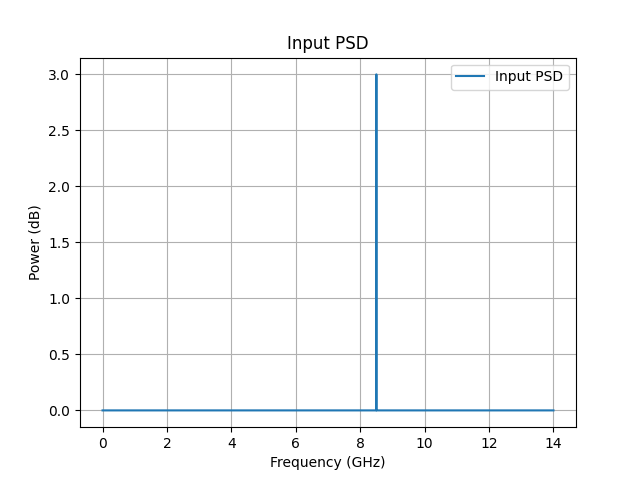

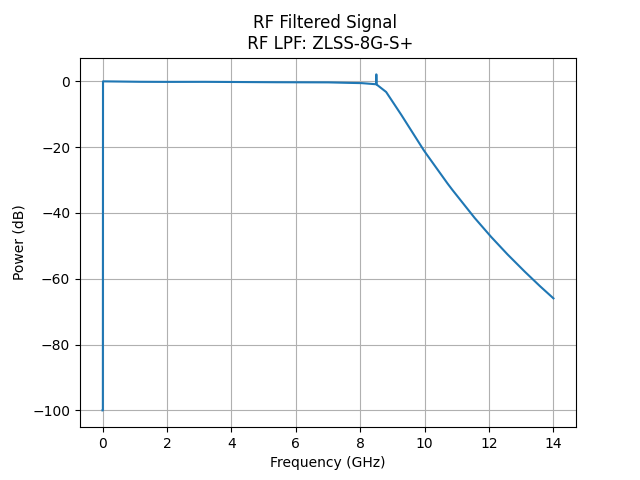

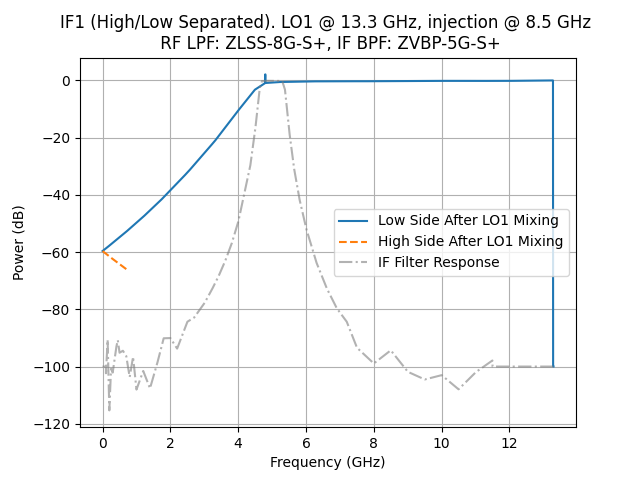

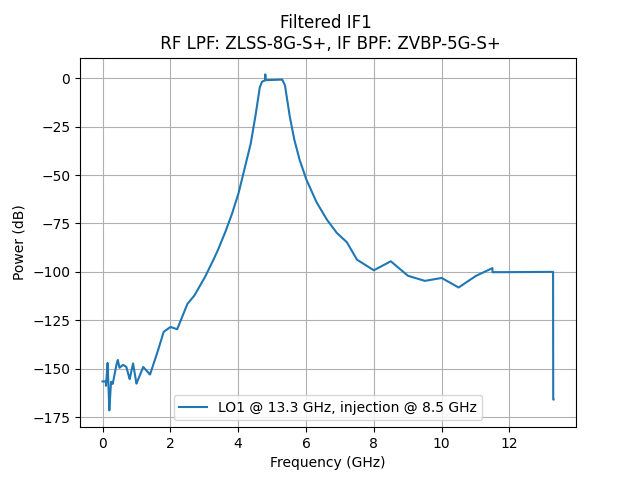

In [7]:
plt.close('all')

injectFreq  = 8.5 #GHz
injectWidth = 0.005 #GHz
injectPow   = 3 #dB

#rf filter parameters
rfStart     = 1 #GHz
rfStop      = 10.5 #GHz

#if filter parameters
ifStart     = 4.7 #GHz
ifStop      = 5.3 #GHz

LO          = 13.3 #GHz

LO_bleed    = 80 #dB above noise floor in power/bin

#freq range is set in the cell above


input_psd = create_input_PSD(freq_range)
LO_bleedArr = create_LO_bleed_PSD(freq_range)

# Plot the input PSD
plt.figure()
plt.plot(freq_range, input_psd, label='Input PSD')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Power (dB)')
plt.title('Input PSD')
plt.legend()
plt.grid(True)


rfFilt      = -RF_filter(freq_range, fromDataFlag=1, path='./filterData/ZLSS_8G_LPF.txt')
# Apply RF filter
rf_filtered = input_psd + rfFilt

# Plot the RF filtered signal
plt.figure()
plt.plot(freq_range, rf_filtered)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Power (dB)')
plt.title('RF Filtered Signal \n RF LPF: ZLSS-8G-S+')
plt.grid(True)

# Mix with LO1
low_side, high_side = mixer(freq_range, LO)
valid_low = ~np.isnan(low_side)
valid_high = ~np.isnan(high_side)

# Get combined IF power
if_freq, combined_if = combined_IF_power(freq_range, rf_filtered, LO)

# Apply IF filter
ifFilt          = -IF_filter(if_freq, fromDataFlag= 1, path = './filterData/ZVBP_5G_S_cavityBPF.txt')
#filtered_if    = combined_if + IF_filter(if_freq)
filtered_if     = combined_if + ifFilt
#filtered_if    = combined_if + IF_response

plt.figure()
plt.plot(low_side[valid_low], rf_filtered[valid_low], label='Low Side After LO1 Mixing')
plt.plot(high_side[valid_high], rf_filtered[valid_high], '--', label='High Side After LO1 Mixing')
plt.plot(if_freq, ifFilt, '-.', label='IF Filter Response', color='grey', alpha=0.6)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Power (dB)')
plt.title(f'IF1 (High/Low Separated). LO1 @ {LO} GHz, injection @ {injectFreq} GHz \n RF LPF: ZLSS-8G-S+, IF BPF: ZVBP-5G-S+')
plt.legend()
plt.grid(True)


# Plot the combined IF
plt.figure()
plt.plot(if_freq, filtered_if, label=f'LO1 @ {LO} GHz, injection @ {injectFreq} GHz')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Power (dB)')
plt.title('Filtered IF1 \n RF LPF: ZLSS-8G-S+, IF BPF: ZVBP-5G-S+')
plt.legend()
plt.grid(True)


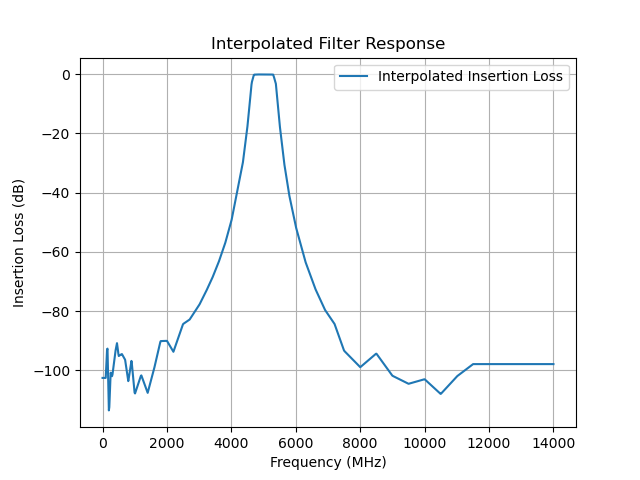

In [34]:
import numpy as np
from scipy.interpolate import interp1d

def read_and_interpolate_filter_data(file_path, freq_range):
    # Read data from the file
    with open(file_path, 'r') as file:
        data = np.array([list(map(float, line.split())) for line in file])
    
    # Extract frequency and insertion loss data
    freqs = data[:, 0]
    insertion_loss = data[:, 1]
    
    # Check for missing data at the start or end of the given frequency range
    if freqs[0] > freq_range[0]:
        freqs = np.insert(freqs, 0, freq_range[0])
        insertion_loss = np.insert(insertion_loss, 0, insertion_loss[0])
    
    if freqs[-1] < freq_range[-1]:
        freqs = np.append(freqs, freq_range[-1])
        insertion_loss = np.append(insertion_loss, insertion_loss[-1])
    
    # Interpolate insertion loss for the given frequency range
    interpolator = interp1d(freqs, insertion_loss, kind='linear', fill_value="extrapolate")
    interpolated_insertion_loss = interpolator(freq_range)
    
    return interpolated_insertion_loss

# Usage:
# Let's assume you saved the provided data in a file named 'filter_data.txt'
# And you want to interpolate the data for a frequency range of 0 to 12000 MHz.
file_path = './filterData/ZVBP_5G_S_cavityBPF.txt'
freq_range = np.linspace(0, 14000, 1000)
interpolated_data = read_and_interpolate_filter_data(file_path, freq_range)

# Plotting the interpolated data
import matplotlib.pyplot as plt

plt.figure()
plt.plot(freq_range, -interpolated_data, label='Interpolated Insertion Loss')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Insertion Loss (dB)')
plt.title('Interpolated Filter Response')
plt.grid(True)
plt.legend()
plt.show()
